In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Scipy & Stats
from scipy.stats import pearsonr

# Scikit-Learn
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import feature_selection as fs  # Keeping this if needed separately

# Batch Effect Correction
from combat.pycombat import pycombat

# Dimensionality Reduction
from umap import UMAP

## Batch Correction

In [2]:
%store -r radiomics
%store -r meta_data

# Extracting batch labels required for combat
batch = pd.factorize(meta_data['TMA'].astype(str) + meta_data['Grid'])[0]
batch = pd.Series(batch)

In [3]:
%store -r ICC
%store -r ICC_features

# Define threshold and p-value criteria
threshold = 0.75
p_value_threshold = 0.05

# Determine reliable and unreliable features
reliable_features = [
    feature for feature in ICC_features
    if (ICC[feature]['ICC'][2] > threshold) and (ICC[feature]['pval'][2] < p_value_threshold)
]

unreliable_features = [feature for feature in ICC_features if feature not in reliable_features]

# Output results
num_reliable = len(reliable_features)
num_unreliable = len(unreliable_features)

print(f"Threshold: {threshold}")
print(f"Reliable features: {num_reliable}")
print(f"Unreliable features: {num_unreliable}")

Threshold: 0.75
Reliable features: 301
Unreliable features: 986


In [4]:
radiomics = radiomics[reliable_features]

# Step 2: Apply log transformation (handling negatives properly)
radiomics_log = np.sign(radiomics) * np.log1p(abs(radiomics))

# Step 3: Transpose (ComBat expects features as rows, samples as columns)
radiomics_transpose = radiomics_log.T  

# Step 4: Apply pyComBat for batch effect correction
radiomics_transpose_corrected = pycombat(radiomics_transpose, batch)

# Step 5: Transpose back (restoring original structure)
radiomics_corrected = radiomics_transpose_corrected.T  

# Ensure column names are preserved
radiomics_corrected.columns = radiomics.columns  
radiomics_corrected.index = radiomics.index  # Restore sample index if needed

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\taki\Anaconda3\envs\RadOmics\lib\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


In [5]:
%store radiomics_corrected

Stored 'radiomics_corrected' (DataFrame)


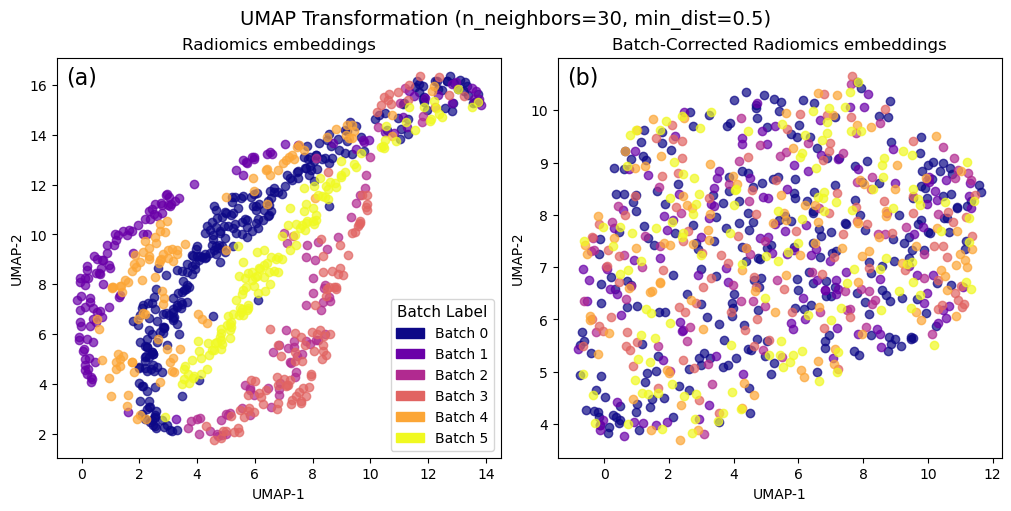

In [6]:
# Define hyperparameters
n_neighbors = 30
min_dist = 0.5

# Create a 1x2 figure (two subplots)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle(f"UMAP Transformation (n_neighbors={n_neighbors}, min_dist={min_dist})", fontsize=14)

# Define colors per batch label
unique_batches = np.unique(batch)
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_batches)))
color_map = dict(zip(unique_batches, colors))

# Map batch labels to colors
batch_colors = np.array([color_map[b] for b in batch])

# Apply UMAP on radiomics
reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, n_jobs=1)
embedding_radiomics = reducer.fit_transform(radiomics)

# First subplot (Radiomics)
for b in unique_batches:
    mask = (batch == b)
    axes[0].scatter(
        embedding_radiomics[mask, 0],
        embedding_radiomics[mask, 1],
        color=color_map[b],
        alpha=0.7,
        label=f"Batch {b}"
    )
axes[0].set_title("Radiomics embeddings")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# Add (a) label to first subplot
axes[0].text(
    0.02, 0.98, '(a)', transform=axes[0].transAxes,
    fontsize=16, fontweight='normal', va='top', ha='left'
)

# Apply UMAP on radiomics_corrected
embedding_radiomics_corrected = reducer.fit_transform(radiomics_corrected)

# Second subplot (Radiomics Corrected)
for b in unique_batches:
    mask = (batch == b)
    axes[1].scatter(
        embedding_radiomics_corrected[mask, 0],
        embedding_radiomics_corrected[mask, 1],
        color=color_map[b],
        alpha=0.7,
        label=f"Batch {b}"
    )
axes[1].set_title("Batch-Corrected Radiomics embeddings")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

# Add (b) label to second subplot
axes[1].text(
    0.02, 0.98, '(b)', transform=axes[1].transAxes,
    fontsize=16, fontweight='normal', va='top', ha='left'
)

# Add legend to the bottom left of the first subplot
handles = [mpatches.Patch(color=color_map[b], label=f"Batch {b}") for b in unique_batches]
axes[0].legend(
    handles=handles,
    title="Batch Label",
    loc="lower right",
    fontsize=10,
    title_fontsize=11
)

# Save and display
plt.savefig("umap_projection.png", bbox_inches="tight", dpi=300)
plt.show()
